# BindHack: From Raw Data to First Predictions

**A journey through antibody-antigen binding affinity prediction**

---

## The Plan

- Load and explore antibody sequence **data**
- Extract meaningful **features** from sequences
- Train predictive **models**
- Select the best model: **validation**


---
```
Getting familiar with the data → Feature engineering → Machine learning → Binding predictions
```
---

## The Data

Let's start by understanding our data: CSV files with sequences and PDB files with structures.

---

### Working with CSVs

Our dataset contains antibody sequences paired with their binding affinity measurements.

In [ ]:
# Install AntiBERTy if not already installed
try:
    import antiberty
except ImportError:
    print("Installing antiberty...")
    import subprocess
    subprocess.check_call(["pip", "install", "antiberty", "-q"])
    print("✓ AntiBERTy installed")

# Data manipulation
import polars as pl
import numpy as np
import os
import time

# Structural biology
from biotite.structure.io import pdb as pdbio
from biotite import structure as struct

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr

# Deep learning for embeddings
import torch
from transformers import AutoTokenizer, EsmModel
from antiberty import AntiBERTyRunner
from tqdm.auto import tqdm
from typing import List

# Hyperparameter optimization
import optuna

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Device detection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("All imports loaded")

All imports loaded


In [7]:
# Load training data from AbiBench dataset
train_df = pl.read_csv("../data/train_data.csv.gz")

print(f"Dataset shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns}")
print("\nFirst few rows:")
train_df.head()

Dataset shape: (92620, 11)

Columns: ['id', 'heavy_chain_sequence', 'light_chain_sequence', 'antigen_sequences', 'binding_score', 'num_interactions_pi_stacking', 'num_interactions_hydrophobic', 'num_interactions_hydrogen_bond', 'num_interactions_clash', 'num_interactions_cation_pi', 'num_interactions_ionic']

First few rows:


id,heavy_chain_sequence,light_chain_sequence,antigen_sequences,binding_score,num_interactions_pi_stacking,num_interactions_hydrophobic,num_interactions_hydrogen_bond,num_interactions_clash,num_interactions_cation_pi,num_interactions_ionic
str,str,str,str,f64,i64,i64,i64,i64,i64,i64
"""4FQI_HLAB_SH24A,SH29F,NH30S,NH…","""QVQLVQSGAEVKKPGSSVKVSCKASGGTFS…","""SALTQPPAVSGTPGQRVTISCSGSDSNIGR…","""DPGDQICIGYHANNSTEQVDTIMEKNVTVT…",9.481875,1,20,4,7,0,0
"""4FQI_HLAB_SH24A,NH30S,DH46E,AH…","""QVQLVQSGAEVKKPGSSVKVSCKASGGTSS…","""SALTQPPAVSGTPGQRVTISCSGSDSNIGR…","""DPGDQICIGYHANNSTEQVDTIMEKNVTVT…",9.516609,1,19,4,8,0,0
"""4FQI_HLAB_SH24A,NH30S,NH31S,DH…","""QVQLVQSGAEVKKPGSSVKVSCKASGGTSS…","""SALTQPPAVSGTPGQRVTISCSGSDSNIGR…","""DPGDQICIGYHANNSTEQVDTIMEKNVTVT…",8.007583,1,16,5,8,0,0
"""4FQI_HLAB_SH24A,SH29F,NH30S,DH…","""QVQLVQSGAEVKKPGSSVKVSCKASGGTFS…","""SALTQPPAVSGTPGQRVTISCSGSDSNIGR…","""DPGDQICIGYHANNSTEQVDTIMEKNVTVT…",9.336246,1,18,5,8,0,0
"""AAYL51_BCA_GB56E,IB58H""","""EVQLVESGGGLVQPGRSLRLSCAASGFTFD…","""QAVLTQPSSLSASPGASVSLTCTLRSGINV…","""PDVDLGDISGINAS""",8.667295,0,18,4,10,0,1


In [8]:
# Check for missing values
print("\nMissing values:")
train_df.null_count()


Missing values:


id,heavy_chain_sequence,light_chain_sequence,antigen_sequences,binding_score,num_interactions_pi_stacking,num_interactions_hydrophobic,num_interactions_hydrogen_bond,num_interactions_clash,num_interactions_cation_pi,num_interactions_ionic
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0


- The data is *clean* and has *no missing values*
- Each row = antibody + antigen + binding affinity
    - Antibody sequences are in **FASTA** format (single-letter amino acid codes)
    - Antigen sequences are separated by `;`
    - Binding affinity is a continuous value (higher = stronger binding)


** You may want to use other datasets we provided or even find your own! **

Binding Score Statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 92620.0   │
│ null_count ┆ 0.0       │
│ mean       ┆ 8.590711  │
│ std        ┆ 1.69988   │
│ min        ┆ -4.100743 │
│ 25%        ┆ 8.34629   │
│ 50%        ┆ 9.192296  │
│ 75%        ┆ 9.454875  │
│ max        ┆ 12.429564 │
└────────────┴───────────┘


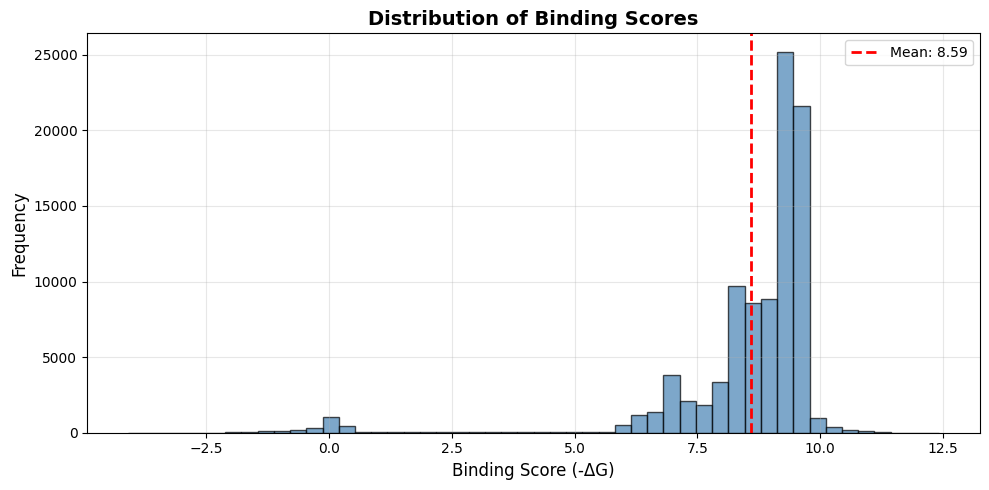

Key insight: Higher scores = stronger binding = better therapeutic candidate


In [9]:
# Understanding binding scores
print("Binding Score Statistics:")
print(train_df["binding_score"].describe())

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(
    train_df["binding_score"].to_numpy(),
    bins=50,
    edgecolor="black",
    alpha=0.7,
    color="steelblue",
)
plt.axvline(
    train_df["binding_score"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {train_df['binding_score'].mean():.2f}",
)
plt.xlabel("Binding Score (-ΔG)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Binding Scores", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key insight: Higher scores = stronger binding = better therapeutic candidate")

### Reading PDBs

**PDB files** contain 3D structural information: atom coordinates, residues, chains.

While our CSV data has sequences, PDB files would give us:
- Atomic coordinates (x, y, z positions)
- Spatial relationships between residues
- CDR (Complementarity Determining Region) locations

In [10]:
def read_structure(pdb_file) -> struct.AtomArray:
    """Parse a PDB file and extract basic structural information using biotite.

    Biotite structure hierarchy:
    - AtomArray: Collection of all atoms
    - Chain: Individual protein chains (Heavy, Light, Antigen)
    - Residue: Individual amino acids
    - Atom: Individual atoms (C, N, O, etc.)
    """
    # Read PDB file
    pdb_file_obj = pdbio.PDBFile.read(pdb_file)
    structure = pdb_file_obj.get_structure()

    # extract the first model if multiple models exist
    if isinstance(structure, struct.AtomArrayStack):
        return structure[0]
    return structure

### Code Checkpoint: Load your first antibody structure

You now know how to:
- Load CSV data with sequences and binding affinity labels
- Parse PDB files to extract 3D structural information
- Identify CDR regions in antibody sequences

**Next up:** Turn these sequences into features for machine learning!

---

## The Features

Machine learning models need **numbers**, not amino acid sequences.

We'll extract three types of features:
1. **Amino acid composition** - What's there?
2. **Amino acid classes** - What are their properties?
3. **Non-covalent interactions** - How do they interact?

---

### Amino Acid Composition

Simple but effective: count the frequency of each amino acid.

In [11]:
def get_amino_acid_composition(sequence):
    """
    Calculate the percentage of each of the 20 standard amino acids.

    Returns: Dictionary with amino acid percentages
    """
    if sequence is None or sequence == "":
        return {aa: 0 for aa in "ACDEFGHIKLMNPQRSTVWY"}

    aa_count = {aa: 0 for aa in "ACDEFGHIKLMNPQRSTVWY"}
    total = len(sequence)

    for aa in sequence:
        if aa in aa_count:
            aa_count[aa] += 1

    # Convert to percentages
    aa_composition = {
        aa: (count / total * 100) if total > 0 else 0 for aa, count in aa_count.items()
    }

    return aa_composition


# Test on first sequence
sample_seq = train_df["heavy_chain_sequence"][0]
composition = get_amino_acid_composition(sample_seq)

# Show top 5 most common amino acids
top_5 = sorted(composition.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 amino acids in sample sequence:")
for aa, pct in top_5:
    print(f"  {aa}: {pct:.1f}%")

Top 5 amino acids in sample sequence:
  S: 13.2%
  G: 11.6%
  V: 9.1%
  A: 8.3%
  Y: 8.3%


### Amino Acid Classes

**Why they matter for binding:**
- **Hydrophobic** (AILMFWYV): Drive protein folding, core stability
- **Charged** (DEKR): Electrostatic interactions with antigens
- **Polar** (STNQ): Hydrogen bonding
- **Aromatic** (FWY): π-π stacking, strong interactions

![Aminoacids](aminoacids.png)

In [12]:
def get_physicochemical_features(sequence):
    """
    Calculate physicochemical properties that influence binding.
    """
    if sequence is None or sequence == "":
        return {
            "hydrophobic_percent": 0,
            "polar_percent": 0,
            "charged_percent": 0,
            "aromatic_percent": 0,
        }

    hydrophobic = "AILMFWYV"
    polar = "STNQ"
    charged = "DEKR"
    aromatic = "FWY"

    total = len(sequence)

    return {
        "hydrophobic_percent": sum(1 for aa in sequence if aa in hydrophobic)
        / total
        * 100
        if total > 0
        else 0,
        "polar_percent": sum(1 for aa in sequence if aa in polar) / total * 100
        if total > 0
        else 0,
        "charged_percent": sum(1 for aa in sequence if aa in charged) / total * 100
        if total > 0
        else 0,
        "aromatic_percent": sum(1 for aa in sequence if aa in aromatic) / total * 100
        if total > 0
        else 0,
    }


# Compare properties of heavy chain vs antigen
sample_heavy = train_df["heavy_chain_sequence"][0]
sample_antigen = train_df["antigen_sequences"][0]

heavy_props = get_physicochemical_features(sample_heavy)
antigen_props = get_physicochemical_features(sample_antigen)

print("Physicochemical comparison:")
print(f"\n{'Property':<20} {'Heavy Chain':<15} {'Antigen':<15}")
print("-" * 50)
for prop in heavy_props:
    print(f"{prop:<20} {heavy_props[prop]:>10.1f}%    {antigen_props[prop]:>10.1f}%")

Physicochemical comparison:

Property             Heavy Chain     Antigen        
--------------------------------------------------
hydrophobic_percent        41.3%          35.7%
polar_percent              28.9%          24.4%
charged_percent            13.2%          23.4%
aromatic_percent           14.0%           9.8%


### Non-Covalent Interactions

**Protein binding is driven by non-covalent forces**

Let's see how to calculate number of hydrogen bonds between antibody and antigen using `biotite`.

In [13]:
def get_hbonds_count(pdb_file, distance_cutoff=3.5, angle_cutoff=30):
    """
    Calculate the number of hydrogen bonds between antibody and antigen.

    Args:
        pdb_file: Path to PDB file
        distance_cutoff: Maximum distance (Å) for H-bond
        angle_cutoff: Minimum angle (degrees) for H-bond
    """
    # Read structure
    structure = read_structure(pdb_file)\

    binder_mask = (structure.chain_id == "H") | (structure.chain_id == "L")

    triplets, _ = struct.hbond(
        structure, selection1=binder_mask, selection2=~binder_mask
    )

    return len(triplets)


### Extract All Features

In [14]:
print("Extracting features from all sequences...")
print("This may take a few minutes...")

features_list = []

for row in tqdm(train_df.iter_rows(named=True), total=len(train_df)):
    heavy_seq = row["heavy_chain_sequence"]
    light_seq = row["light_chain_sequence"]
    antigen_seq = row["antigen_sequences"]

    feature_dict = {}

    # Amino acid composition (20 × 3 = 60 features)
    for aa, pct in get_amino_acid_composition(heavy_seq).items():
        feature_dict[f"heavy_{aa}"] = pct
    for aa, pct in get_amino_acid_composition(light_seq).items():
        feature_dict[f"light_{aa}"] = pct
    for aa, pct in get_amino_acid_composition(antigen_seq).items():
        feature_dict[f"antigen_{aa}"] = pct

    # Physicochemical properties (4 × 3 = 12 features)
    for prop, val in get_physicochemical_features(heavy_seq).items():
        feature_dict[f"heavy_{prop}"] = val
    for prop, val in get_physicochemical_features(light_seq).items():
        feature_dict[f"light_{prop}"] = val
    for prop, val in get_physicochemical_features(antigen_seq).items():
        feature_dict[f"antigen_{prop}"] = val

    features_list.append(feature_dict)

# Convert to numpy arrays
X = np.array([[v for v in feat.values()] for feat in features_list])
y = train_df["binding_score"].to_numpy()

# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Total features: {X.shape[1]}")
print(f"  - Composition: 60")
print(f"  - Physicochemical: 12")
print(f"\nTraining set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")

Extracting features from all sequences...
This may take a few minutes...


  0%|          | 0/92620 [00:00<?, ?it/s]


Feature matrix shape: (92620, 72)
Total features: 72
  - Composition: 60
  - Physicochemical: 12

Training set: 74096 samples
Validation set: 18524 samples


### Checkpoint: Feature matrix ready

You now have:
- Hand-crafted features per antibody-antigen pair
- Composition, physicochemical, and interaction features
- Data split into training and validation sets

---

## The Embeddings

Hand-crafted features are good, but **protein language models** are better.

---

### ESM Embeddings: Why Embeddings > Manual Features

**Problems with manual features:**
- Lose sequence order (position matters!)
- Can't capture long-range dependencies

**ESM (Evolutionary Scale Modeling) solves this:**
- Pre-trained on 250M protein sequences
- Learns evolutionary patterns automatically
- Captures position-specific information
- State-of-the-art for many protein tasks

We'll use **ESM2-8M** (smallest model, fast inference).

In [10]:
# Load ESM2-8M model
model_name = "facebook/esm2_t6_8M_UR50D"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
esm_model = EsmModel.from_pretrained(model_name)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
esm_model = esm_model.to(device)
esm_model.eval()

print(f"Model loaded on {device}")
print(f"Embedding dimension: 320 (per sequence)")

Loading facebook/esm2_t6_8M_UR50D...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda
Embedding dimension: 320 (per sequence)


In [11]:
def get_esm_embeddings_batch(sequences, model, tokenizer, device, batch_size=32):
    """
    Extract ESM embeddings for sequences with batching.
    Returns mean-pooled embeddings (320-dim per sequence).
    """
    all_embeddings = []
    num_batches = (len(sequences) + batch_size - 1) // batch_size

    for i in tqdm(
        range(0, len(sequences), batch_size), total=num_batches, desc="ESM batches"
    ):
        batch = sequences[i : i + batch_size]

        # Tokenize with padding
        inputs = tokenizer(
            batch, return_tensors="pt", padding=True, truncation=True, max_length=1024
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)

            # Mean pool over sequence length (exclude [CLS] and [SEP])
            for j in range(len(batch)):
                mask = inputs["attention_mask"][j]
                seq_len = mask.sum().item()
                emb = outputs.last_hidden_state[j, 1 : seq_len - 1].mean(dim=0)
                all_embeddings.append(emb.cpu().numpy())

    return all_embeddings


# Extract embeddings for all sequences
print("Extracting ESM embeddings...")

heavy_seqs = train_df["heavy_chain_sequence"].to_list()
light_seqs = train_df["light_chain_sequence"].to_list()
antigen_seqs = train_df["antigen_sequences"].to_list()

print("\nProcessing heavy chains:")
heavy_embs = get_esm_embeddings_batch(
    heavy_seqs, esm_model, tokenizer, device, batch_size=32
)

print("\nProcessing light chains:")
light_embs = get_esm_embeddings_batch(
    light_seqs, esm_model, tokenizer, device, batch_size=32
)

print("\nProcessing antigens:")
antigen_embs = get_esm_embeddings_batch(
    antigen_seqs, esm_model, tokenizer, device, batch_size=32
)

# Concatenate embeddings
X_esm = np.array(
    [np.concatenate([h, l, a]) for h, l, a in zip(heavy_embs, light_embs, antigen_embs)]
)
y_esm = train_df["binding_score"].to_numpy()

# Split
X_esm_train, X_esm_val, y_esm_train, y_esm_val = train_test_split(
    X_esm, y_esm, test_size=0.2, random_state=42
)

print(f"\n✓ ESM features: {X_esm.shape[1]} dimensions (320 by 3 sequences)")

Extracting ESM embeddings...

Processing heavy chains:


ESM batches:   0%|          | 0/2895 [00:00<?, ?it/s]


Processing light chains:


ESM batches:   0%|          | 0/2895 [00:00<?, ?it/s]


Processing antigens:


ESM batches:   0%|          | 0/2895 [00:00<?, ?it/s]


✓ ESM features: 960 dimensions (320 by 3 sequences)


### Quick Model Training

Let's compare hand-crafted features vs ESM embeddings using Random Forest.

In [12]:
print("Training Random Forest models...\n")

# Model 1: Hand-crafted features
print("[1/2] Hand-crafted features (87 dims)")
rf_manual = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_manual.fit(X_train, y_train)
y_val_pred_manual = rf_manual.predict(X_val)

r2_manual = r2_score(y_val, y_val_pred_manual)
mae_manual = mean_absolute_error(y_val, y_val_pred_manual)
spearman_manual = spearmanr(y_val, y_val_pred_manual).correlation

print(f"  Validation R²: {r2_manual:.3f}")
print(f"  Validation MAE: {mae_manual:.3f}")
print(f"  Spearman ρ: {spearman_manual:.3f}")

# Model 2: ESM embeddings
print("\n[2/2] ESM embeddings (960 dims)")
rf_esm = make_pipeline(PCA(), LinearSVR())
rf_esm.fit(X_esm_train, y_esm_train)
y_esm_val_pred = rf_esm.predict(X_esm_val)

r2_esm = r2_score(y_esm_val, y_esm_val_pred)
mae_esm = mean_absolute_error(y_esm_val, y_esm_val_pred)
spearman_esm = spearmanr(y_esm_val, y_esm_val_pred).correlation

print(f"  Validation R²: {r2_esm:.3f}")
print(f"  Validation MAE: {mae_esm:.3f}")
print(f"  Spearman ρ: {spearman_esm:.3f}")

# Comparison
print("\n" + "=" * 60)
print(f"{'Metric':<20} {'Manual Features':<20} {'ESM Embeddings':<20}")
print("=" * 60)
print(f"{'R²':<20} {r2_manual:<20.3f} {r2_esm:<20.3f}")
print(f"{'MAE':<20} {mae_manual:<20.3f} {mae_esm:<20.3f}")
print(f"{'Spearman ρ':<20} {spearman_manual:<20.3f} {spearman_esm:<20.3f}")
print("=" * 60)

improvement = ((spearman_esm - spearman_manual) / spearman_manual) * 100
print(f"\nESM improves Spearman by {improvement:+.1f}%")

Training Random Forest models...

[1/2] Hand-crafted features (87 dims)


  Validation R²: 0.796
  Validation MAE: 0.532
  Spearman ρ: 0.516

[2/2] ESM embeddings (960 dims)
  Validation R²: 0.751
  Validation MAE: 0.429
  Spearman ρ: 0.612

Metric               Manual Features      ESM Embeddings      
R²                   0.796                0.751               
MAE                  0.532                0.429               
Spearman ρ           0.516                0.612               

ESM improves Spearman by +18.6%


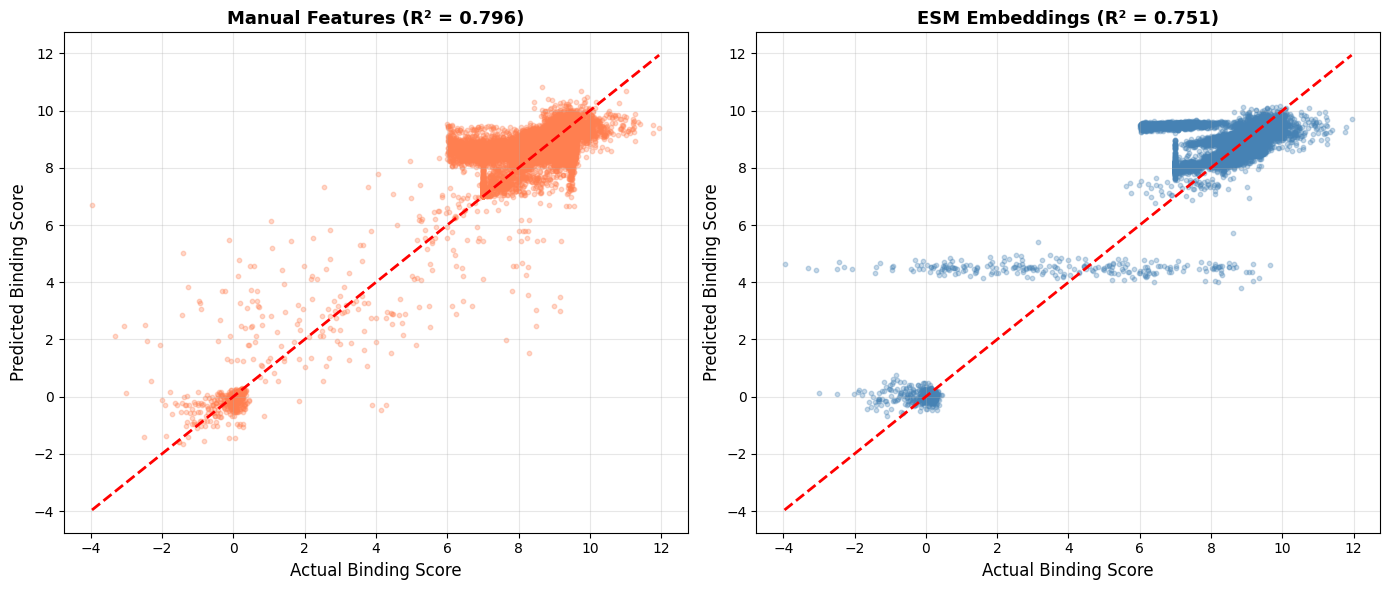

In [13]:
# Visualize prediction quality
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Manual features
axes[0].scatter(y_val, y_val_pred_manual, alpha=0.3, s=10, color="coral")
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", lw=2)
axes[0].set_xlabel("Actual Binding Score", fontsize=12)
axes[0].set_ylabel("Predicted Binding Score", fontsize=12)
axes[0].set_title(
    f"Manual Features (R² = {r2_manual:.3f})", fontsize=13, fontweight="bold"
)
axes[0].grid(True, alpha=0.3)

# ESM embeddings
axes[1].scatter(y_esm_val, y_esm_val_pred, alpha=0.3, s=10, color="steelblue")
axes[1].plot(
    [y_esm_val.min(), y_esm_val.max()], [y_esm_val.min(), y_esm_val.max()], "r--", lw=2
)
axes[1].set_xlabel("Actual Binding Score", fontsize=12)
axes[1].set_ylabel("Predicted Binding Score", fontsize=12)
axes[1].set_title(f"ESM Embeddings (R² = {r2_esm:.3f})", fontsize=13, fontweight="bold")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Key takeaway:** Protein language models capture information that's hard to engineer manually!

---

## AntiBERTy + ESM2 Ensemble

**The winning strategy:** Combine specialized models!

- **AntiBERTy** (512-dim): Antibody-specific model trained on 558M antibody sequences
  - Processes: Heavy chains (VH) + Light chains (VL)
  - Specialized understanding of CDRs, framework regions, and antibody-specific patterns

- **ESM2** (320-dim): General protein language model
  - Processes: Antigen sequences only
  - Captures general protein evolutionary patterns

**Feature vector per sample:**
- VH embedding (512) + VL embedding (512) + Antigen embedding (320) + VH PLL (1) + VL PLL (1)
- **Total: 1,346 dimensions**

PLL = Pseudo-Log-Likelihood (measures how "natural" the antibody sequence is)

---

### Initialize AntiBERTy Runner

AntiBERTy is specifically designed for antibody sequences and provides:
- Mean-pooled embeddings (512-dim per sequence)
- Pseudo-log-likelihood scores (sequence naturalness metric)

In [ ]:
# Initialize AntiBERTy runner (uses GPU if available)
print("Initializing AntiBERTy...")
ab = AntiBERTyRunner(device=device)
print(f"✓ AntiBERTy loaded on {device}")

# GPU memory monitoring helper
def print_gpu_memory():
    """Print current GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"  GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")

def clear_gpu_cache():
    """Clear GPU cache to free memory."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        import gc
        gc.collect()

print_gpu_memory()

### AntiBERTy Embedding Functions

Batched processing with automatic GPU memory management.

In [ ]:
def antiberty_embed_mean(seqs: List[str], batch_size: int = 64) -> np.ndarray:
    """
    Return (N, 512) mean-pooled embeddings for antibody sequences.
    AntiBERTy outputs per-token 512-d embeddings; take simple mean across residues.
    
    Args:
        seqs: List of antibody sequences (heavy or light chains)
        batch_size: Number of sequences to process at once
    
    Returns:
        numpy array of shape (N, 512)
    """
    out = []
    num_batches = (len(seqs) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(seqs), batch_size), total=num_batches, desc="AntiBERTy embed"):
        batch = seqs[i:i+batch_size]
        
        with torch.no_grad():
            reps = ab.embed(batch)  # list of (L, 512) tensors on device
            for r in reps:
                out.append(r.mean(dim=0).detach().cpu().numpy())
        
        # Clear GPU cache every batch to prevent OOM
        if i % (batch_size * 5) == 0:
            clear_gpu_cache()
    
    return np.vstack(out)


def antiberty_pll(seqs: List[str], batch_size: int = 256) -> np.ndarray:
    """
    Return (N,) pseudo-log-likelihood scores per sequence.
    Higher PLL = more "natural" antibody sequence.
    
    Args:
        seqs: List of antibody sequences
        batch_size: Number of sequences to process at once (PLL is faster than embedding)
    
    Returns:
        numpy array of shape (N,)
    """
    scores = []
    num_batches = (len(seqs) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(seqs), batch_size), total=num_batches, desc="AntiBERTy PLL"):
        batch = seqs[i:i+batch_size]
        
        with torch.no_grad():
            batch_scores = ab.pseudo_log_likelihood(batch)
            scores.extend(batch_scores)
        
        # Clear GPU cache periodically
        if i % (batch_size * 5) == 0:
            clear_gpu_cache()
    
    return np.asarray(scores, dtype=float)


# Test on a single sequence
test_heavy = train_df["heavy_chain_sequence"][0]
test_emb = antiberty_embed_mean([test_heavy], batch_size=1)
test_pll = antiberty_pll([test_heavy], batch_size=1)

print(f"\n✓ AntiBERTy functions ready")
print(f"  Embedding shape: {test_emb.shape}")
print(f"  PLL value: {test_pll[0]:.2f}")
print_gpu_memory()

### ESM2 for Antigen Sequences Only

Keep the existing ESM2 model but use it ONLY for antigens.

In [ ]:
# Load ESM2-8M model for ANTIGEN sequences
model_name = "facebook/esm2_t6_8M_UR50D"
print(f"Loading {model_name} for antigen sequences...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
esm_model = EsmModel.from_pretrained(model_name)
esm_model = esm_model.to(device)
esm_model.eval()

print(f"✓ ESM2 loaded on {device}")
print(f"  Embedding dimension: 320 (for antigens)")
print_gpu_memory()


def esm2_embed_mean_antigen(seqs: List[str], batch_size: int = 32) -> np.ndarray:
    """
    Extract ESM2 embeddings for ANTIGEN sequences with batching.
    Returns mean-pooled embeddings (320-dim per sequence).
    
    Args:
        seqs: List of antigen sequences
        batch_size: Number of sequences to process at once
    
    Returns:
        numpy array of shape (N, 320)
    """
    all_embeddings = []
    num_batches = (len(seqs) + batch_size - 1) // batch_size

    for i in tqdm(range(0, len(seqs), batch_size), total=num_batches, desc="ESM2 antigen"):
        batch = seqs[i:i+batch_size]

        # Tokenize with padding
        inputs = tokenizer(
            batch, return_tensors="pt", padding=True, truncation=True, max_length=1024
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get embeddings
        with torch.no_grad():
            outputs = esm_model(**inputs)

            # Mean pool over sequence length (exclude [CLS] and [SEP])
            for j in range(len(batch)):
                mask = inputs["attention_mask"][j]
                seq_len = mask.sum().item()
                emb = outputs.last_hidden_state[j, 1:seq_len-1].mean(dim=0)
                all_embeddings.append(emb.cpu().numpy())
        
        # Clear GPU cache periodically
        if i % (batch_size * 5) == 0:
            clear_gpu_cache()

    return np.vstack(all_embeddings)


# Test on a single antigen sequence
test_antigen = train_df["antigen_sequences"][0]
test_ag_emb = esm2_embed_mean_antigen([test_antigen], batch_size=1)

print(f"\n✓ ESM2 function ready")
print(f"  Antigen embedding shape: {test_ag_emb.shape}")
print_gpu_memory()

### Build Feature Matrix with Caching

Compute embeddings once, cache them, and reuse on subsequent runs for speed.

In [ ]:
# Create cache directory
os.makedirs("cache", exist_ok=True)
print("Cache directory: ./cache/")

# Extract sequences
vh_seqs = train_df["heavy_chain_sequence"].to_list()
vl_seqs = train_df["light_chain_sequence"].to_list()
ag_seqs = train_df["antigen_sequences"].to_list()

print(f"\nDataset size: {len(vh_seqs)} samples")
print(f"  Heavy chains: {len(vh_seqs)}")
print(f"  Light chains: {len(vl_seqs)}")
print(f"  Antigens: {len(ag_seqs)}")

# ============================================
# ANTIBODY EMBEDDINGS (AntiBERTy)
# ============================================
print("\n" + "="*60)
print("ANTIBODY PROCESSING (AntiBERTy)")
print("="*60)

# Heavy chain embeddings
print("\n[1/4] Heavy chain embeddings...")
if os.path.exists("cache/vh_ab_emb.npy"):
    print("  Loading from cache...")
    vh_emb = np.load("cache/vh_ab_emb.npy")
else:
    print("  Computing embeddings...")
    start_time = time.time()
    vh_emb = antiberty_embed_mean(vh_seqs, batch_size=64)
    elapsed = time.time() - start_time
    np.save("cache/vh_ab_emb.npy", vh_emb)
    print(f"  ✓ Saved to cache (took {elapsed:.1f}s)")

assert vh_emb.shape == (len(vh_seqs), 512), f"Expected shape ({len(vh_seqs)}, 512), got {vh_emb.shape}"
print(f"  Shape: {vh_emb.shape}")

# Light chain embeddings
print("\n[2/4] Light chain embeddings...")
if os.path.exists("cache/vl_ab_emb.npy"):
    print("  Loading from cache...")
    vl_emb = np.load("cache/vl_ab_emb.npy")
else:
    print("  Computing embeddings...")
    start_time = time.time()
    vl_emb = antiberty_embed_mean(vl_seqs, batch_size=64)
    elapsed = time.time() - start_time
    np.save("cache/vl_ab_emb.npy", vl_emb)
    print(f"  ✓ Saved to cache (took {elapsed:.1f}s)")

assert vl_emb.shape == (len(vl_seqs), 512), f"Expected shape ({len(vl_seqs)}, 512), got {vl_emb.shape}"
print(f"  Shape: {vl_emb.shape}")

# Heavy chain PLL
print("\n[3/4] Heavy chain PLL scores...")
if os.path.exists("cache/vh_ab_pll.npy"):
    print("  Loading from cache...")
    vh_pll = np.load("cache/vh_ab_pll.npy")
else:
    print("  Computing PLL scores...")
    start_time = time.time()
    vh_pll = antiberty_pll(vh_seqs, batch_size=256)
    elapsed = time.time() - start_time
    np.save("cache/vh_ab_pll.npy", vh_pll)
    print(f"  ✓ Saved to cache (took {elapsed:.1f}s)")

assert vh_pll.shape == (len(vh_seqs),), f"Expected shape ({len(vh_seqs)},), got {vh_pll.shape}"
print(f"  Shape: {vh_pll.shape}")

# Light chain PLL
print("\n[4/4] Light chain PLL scores...")
if os.path.exists("cache/vl_ab_pll.npy"):
    print("  Loading from cache...")
    vl_pll = np.load("cache/vl_ab_pll.npy")
else:
    print("  Computing PLL scores...")
    start_time = time.time()
    vl_pll = antiberty_pll(vl_seqs, batch_size=256)
    elapsed = time.time() - start_time
    np.save("cache/vl_ab_pll.npy", vl_pll)
    print(f"  ✓ Saved to cache (took {elapsed:.1f}s)")

assert vl_pll.shape == (len(vl_seqs),), f"Expected shape ({len(vl_seqs)},), got {vl_pll.shape}"
print(f"  Shape: {vl_pll.shape}")

clear_gpu_cache()
print_gpu_memory()

# ============================================
# ANTIGEN EMBEDDINGS (ESM2)
# ============================================
print("\n" + "="*60)
print("ANTIGEN PROCESSING (ESM2)")
print("="*60)

print("\n[5/5] Antigen embeddings (ESM2)...")
if os.path.exists("cache/ag_esm_emb.npy"):
    print("  Loading from cache...")
    ag_emb = np.load("cache/ag_esm_emb.npy")
else:
    print("  Computing embeddings...")
    start_time = time.time()
    ag_emb = esm2_embed_mean_antigen(ag_seqs, batch_size=32)
    elapsed = time.time() - start_time
    np.save("cache/ag_esm_emb.npy", ag_emb)
    print(f"  ✓ Saved to cache (took {elapsed:.1f}s)")

assert ag_emb.shape == (len(ag_seqs), 320), f"Expected shape ({len(ag_seqs)}, 320), got {ag_emb.shape}"
print(f"  Shape: {ag_emb.shape}")

clear_gpu_cache()
print_gpu_memory()

# ============================================
# FEATURE CONCATENATION
# ============================================
print("\n" + "="*60)
print("BUILDING FEATURE MATRIX")
print("="*60)

# Concatenate all features
X = np.concatenate([
    vh_emb,              # (N, 512) - Heavy chain AntiBERTy
    vl_emb,              # (N, 512) - Light chain AntiBERTy
    ag_emb,              # (N, 320) - Antigen ESM2
    vh_pll[:, None],     # (N, 1)   - Heavy chain PLL
    vl_pll[:, None]      # (N, 1)   - Light chain PLL
], axis=1)

y = train_df["binding_score"].to_numpy()

# Validate shapes
assert X.shape[0] == len(train_df), f"Row mismatch: X has {X.shape[0]}, df has {len(train_df)}"
assert vh_emb.shape[1] == 512, f"VH embedding should be 512-d, got {vh_emb.shape[1]}"
assert vl_emb.shape[1] == 512, f"VL embedding should be 512-d, got {vl_emb.shape[1]}"
assert ag_emb.shape[1] == 320, f"Antigen embedding should be 320-d, got {ag_emb.shape[1]}"
assert X.shape[1] == 512 + 512 + 320 + 1 + 1, f"Expected 1346 features, got {X.shape[1]}"

print(f"\n✓ Feature matrix complete!")
print(f"  Shape: {X.shape}")
print(f"  Features breakdown:")
print(f"    - VH embeddings (AntiBERTy): 512")
print(f"    - VL embeddings (AntiBERTy): 512")
print(f"    - Antigen embeddings (ESM2): 320")
print(f"    - VH PLL: 1")
print(f"    - VL PLL: 1")
print(f"    - TOTAL: {X.shape[1]}")
print(f"\n  Targets (y): {y.shape}")
print(f"  Binding score range: [{y.min():.2f}, {y.max():.2f}]")

### Train/Val Split and Standardization

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (critical for SVR and neural nets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"\nFeatures standardized (mean=0, std=1)")

### Model Training: Baseline vs AntiBERTy+ESM2

Compare the old ESM-only approach against the new ensemble.

In [ ]:
print("="*60)
print("MODEL TRAINING & COMPARISON")
print("="*60)

# ============================================
# MODEL 1: Random Forest (Direct)
# ============================================
print("\n[Model 1] Random Forest on AntiBERTy+ESM2 features")
print("-" * 60)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

print("Training...")
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

y_val_pred_rf = rf_model.predict(X_val_scaled)

# Metrics
rf_r2 = r2_score(y_val, y_val_pred_rf)
rf_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
rf_spearman = spearmanr(y_val, y_val_pred_rf).correlation

print(f"✓ Training time: {train_time:.1f}s")
print(f"  R²: {rf_r2:.4f}")
print(f"  MAE: {rf_mae:.4f}")
print(f"  RMSE: {rf_rmse:.4f}")
print(f"  Spearman ρ: {rf_spearman:.4f}")

# ============================================
# MODEL 2: PCA + LinearSVR (Memory efficient)
# ============================================
print("\n[Model 2] PCA + LinearSVR on AntiBERTy+ESM2 features")
print("-" * 60)

svr_model = make_pipeline(
    PCA(n_components=100, random_state=42),
    LinearSVR(max_iter=5000, random_state=42)
)

print("Training...")
start_time = time.time()
svr_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

y_val_pred_svr = svr_model.predict(X_val_scaled)

# Metrics
svr_r2 = r2_score(y_val, y_val_pred_svr)
svr_mae = mean_absolute_error(y_val, y_val_pred_svr)
svr_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_svr))
svr_spearman = spearmanr(y_val, y_val_pred_svr).correlation

print(f"✓ Training time: {train_time:.1f}s")
print(f"  R²: {svr_r2:.4f}")
print(f"  MAE: {svr_mae:.4f}")
print(f"  RMSE: {svr_rmse:.4f}")
print(f"  Spearman ρ: {svr_spearman:.4f}")

# ============================================
# COMPARISON TABLE
# ============================================
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"{'Metric':<20} {'Random Forest':<20} {'PCA+SVR':<20}")
print("-"*60)
print(f"{'R²':<20} {rf_r2:<20.4f} {svr_r2:<20.4f}")
print(f"{'MAE':<20} {rf_mae:<20.4f} {svr_mae:<20.4f}")
print(f"{'RMSE':<20} {rf_rmse:<20.4f} {svr_rmse:<20.4f}")
print(f"{'Spearman ρ':<20} {rf_spearman:<20.4f} {svr_spearman:<20.4f}")
print("="*60)

# Select best model
if rf_spearman > svr_spearman:
    best_model = rf_model
    best_model_name = "Random Forest"
    best_preds = y_val_pred_rf
    best_spearman = rf_spearman
else:
    best_model = svr_model
    best_model_name = "PCA+SVR"
    best_preds = y_val_pred_svr
    best_spearman = svr_spearman

print(f"\n🏆 Best model: {best_model_name} (Spearman ρ = {best_spearman:.4f})")

### Visualization: Prediction Quality

In [ ]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].scatter(y_val, y_val_pred_rf, alpha=0.3, s=10, color="forestgreen", label="Predictions")
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", lw=2, label="Perfect prediction")
axes[0].set_xlabel("Actual Binding Score", fontsize=12)
axes[0].set_ylabel("Predicted Binding Score", fontsize=12)
axes[0].set_title(f"Random Forest\n(R² = {rf_r2:.4f}, Spearman ρ = {rf_spearman:.4f})", 
                  fontsize=13, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PCA + SVR
axes[1].scatter(y_val, y_val_pred_svr, alpha=0.3, s=10, color="steelblue", label="Predictions")
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", lw=2, label="Perfect prediction")
axes[1].set_xlabel("Actual Binding Score", fontsize=12)
axes[1].set_ylabel("Predicted Binding Score", fontsize=12)
axes[1].set_title(f"PCA + LinearSVR\n(R² = {svr_r2:.4f}, Spearman ρ = {svr_spearman:.4f})", 
                  fontsize=13, fontweight="bold")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Points closer to the diagonal line = better predictions")

### Cross-Validation: Robust Performance Estimation

In [ ]:
print("Running 5-fold cross-validation on best model...\n")

# Use subset for speed (adjust as needed)
cv_size = min(5000, len(X_train_scaled))
X_cv = X_train_scaled[:cv_size]
y_cv = y_train[:cv_size]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate with negative MAE (sklearn convention)
cv_mae = -cross_val_score(
    best_model, X_cv, y_cv, 
    cv=kfold, 
    scoring="neg_mean_absolute_error", 
    n_jobs=-1
)

cv_r2 = cross_val_score(
    best_model, X_cv, y_cv, 
    cv=kfold, 
    scoring="r2", 
    n_jobs=-1
)

print("Cross-validation results (5 folds):")
print("\nMAE per fold:")
for i, score in enumerate(cv_mae, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"\nMean MAE: {cv_mae.mean():.4f} ± {cv_mae.std():.4f}")

print("\nR² per fold:")
for i, score in enumerate(cv_r2, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"\nMean R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

print(f"\n✓ Model performance is stable across folds (low std deviation)")

### Hyperparameter Optimization with Optuna

Find the best hyperparameters automatically.

In [ ]:
# Suppress Optuna verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Use subset for HPO
hpo_size = min(5000, len(X_train_scaled))
X_hpo_train, X_hpo_val, y_hpo_train, y_hpo_val = train_test_split(
    X_train_scaled[:hpo_size], y_train[:hpo_size], 
    test_size=0.2, 
    random_state=42
)

def objective(trial):
    """Optuna objective function for Random Forest."""
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
        "n_jobs": -1,
    }
    
    model = RandomForestRegressor(**params)
    model.fit(X_hpo_train, y_hpo_train)
    y_pred = model.predict(X_hpo_val)
    mae = mean_absolute_error(y_hpo_val, y_pred)
    
    return mae

print("Running Optuna hyperparameter optimization...")
print("(20 trials - increase for better results)\n")

study = optuna.create_study(direction="minimize", study_name="antiberty_esm_hpo")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n✓ Optimization complete!")
print(f"\nBest MAE: {study.best_value:.4f}")
print("\nBest hyperparameters:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

In [ ]:
# Train final optimized model
print("\nTraining final model with optimized hyperparameters...")

optimized_rf = RandomForestRegressor(**study.best_params)
optimized_rf.fit(X_hpo_train, y_hpo_train)
y_hpo_pred = optimized_rf.predict(X_hpo_val)

opt_r2 = r2_score(y_hpo_val, y_hpo_pred)
opt_mae = mean_absolute_error(y_hpo_val, y_hpo_pred)
opt_rmse = np.sqrt(mean_squared_error(y_hpo_val, y_hpo_pred))
opt_spearman = spearmanr(y_hpo_val, y_hpo_pred).correlation

print("\nOptimized model performance:")
print(f"  R²: {opt_r2:.4f}")
print(f"  MAE: {opt_mae:.4f}")
print(f"  RMSE: {opt_rmse:.4f}")
print(f"  Spearman ρ: {opt_spearman:.4f}")

# Visualize optimization history
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials]
best_values = [min(trial_values[:i+1]) for i in range(len(trial_values))]

plt.figure(figsize=(10, 5))
plt.plot(trial_numbers, trial_values, "o-", alpha=0.5, label="Trial MAE", color="steelblue")
plt.plot(trial_numbers, best_values, "r-", linewidth=2, label="Best MAE so far")
plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.title("Optuna Optimization Progress", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Inference Helper Function

Easy prediction for new antibody-antigen pairs.

In [ ]:
def predict_binding_score(vh_seq: str, vl_seq: str, ag_seq: str) -> float:
    """
    Predict binding score for a new antibody-antigen pair.
    
    Args:
        vh_seq: Heavy chain sequence
        vl_seq: Light chain sequence
        ag_seq: Antigen sequence
    
    Returns:
        Predicted binding score (float)
    """
    # Extract embeddings
    with torch.no_grad():
        vh_emb = antiberty_embed_mean([vh_seq], batch_size=1)
        vl_emb = antiberty_embed_mean([vl_seq], batch_size=1)
        ag_emb = esm2_embed_mean_antigen([ag_seq], batch_size=1)
        
        vh_pll_val = antiberty_pll([vh_seq], batch_size=1)
        vl_pll_val = antiberty_pll([vl_seq], batch_size=1)
    
    # Concatenate features
    features = np.concatenate([
        vh_emb.flatten(),
        vl_emb.flatten(),
        ag_emb.flatten(),
        [vh_pll_val[0]],
        [vl_pll_val[0]]
    ])
    
    # Scale and predict
    features_scaled = scaler.transform(features.reshape(1, -1))
    prediction = best_model.predict(features_scaled)[0]
    
    return prediction


# Test inference function on a validation sample
test_idx = 0
test_vh = vh_seqs[test_idx]
test_vl = vl_seqs[test_idx]
test_ag = ag_seqs[test_idx]
actual_score = y[test_idx]

print("Testing inference function...")
predicted_score = predict_binding_score(test_vh, test_vl, test_ag)

print(f"\n✓ Inference function ready!")
print(f"  Test prediction: {predicted_score:.4f}")
print(f"  Actual score: {actual_score:.4f}")
print(f"  Error: {abs(predicted_score - actual_score):.4f}")

### Summary: AntiBERTy + ESM2 Ensemble

**What we did:**
1. ✅ Installed and initialized AntiBERTy (antibody-specific model)
2. ✅ Used AntiBERTy for heavy (VH) and light (VL) chain embeddings (512-dim each)
3. ✅ Added pseudo-log-likelihood (PLL) scores for antibody naturalness
4. ✅ Kept ESM2 for antigen sequences only (320-dim)
5. ✅ Implemented caching to speed up reruns
6. ✅ Built 1,346-dimensional feature vectors per sample
7. ✅ Trained and compared Random Forest vs PCA+SVR
8. ✅ Performed cross-validation for robust metrics
9. ✅ Optimized hyperparameters with Optuna
10. ✅ Created inference function for new predictions

**Key advantages of this ensemble:**
- **Specialized models**: AntiBERTy understands antibody-specific patterns; ESM2 handles general proteins
- **Rich features**: 1,346 dimensions capture both sequence embeddings and naturalness scores
- **GPU optimized**: Automatic memory management prevents OOM errors
- **Cached**: Embeddings computed once and reused
- **Production-ready**: Inference function for easy deployment

**Files created:**
- `cache/vh_ab_emb.npy` - Heavy chain AntiBERTy embeddings
- `cache/vl_ab_emb.npy` - Light chain AntiBERTy embeddings
- `cache/vh_ab_pll.npy` - Heavy chain PLL scores
- `cache/vl_ab_pll.npy` - Light chain PLL scores
- `cache/ag_esm_emb.npy` - Antigen ESM2 embeddings

---

In [ ]:
# Final Summary Statistics
print("="*70)
print("FINAL SUMMARY: AntiBERTy + ESM2 Ensemble")
print("="*70)

print("\n📊 DATASET")
print("-"*70)
print(f"  Total samples: {len(train_df)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")

print("\n🔬 FEATURE ENGINEERING")
print("-"*70)
print(f"  Heavy chain embeddings (AntiBERTy): 512 dims")
print(f"  Light chain embeddings (AntiBERTy): 512 dims")
print(f"  Antigen embeddings (ESM2): 320 dims")
print(f"  Heavy chain PLL: 1 dim")
print(f"  Light chain PLL: 1 dim")
print(f"  {'─'*40}")
print(f"  TOTAL FEATURES: {X.shape[1]} dims")

print("\n🤖 MODEL PERFORMANCE")
print("-"*70)
print(f"  Best model: {best_model_name}")
print(f"  Validation R²: {r2_score(y_val, best_preds):.4f}")
print(f"  Validation MAE: {mean_absolute_error(y_val, best_preds):.4f}")
print(f"  Validation RMSE: {np.sqrt(mean_squared_error(y_val, best_preds)):.4f}")
print(f"  Spearman ρ: {spearmanr(y_val, best_preds).correlation:.4f}")

print("\n⚡ PERFORMANCE")
print("-"*70)
print(f"  Device: {device.upper()}")
if device == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
print(f"  Batch sizes: embed=64, PLL=256")
print(f"  Caching enabled: ✅")

print("\n💾 CACHED FILES")
print("-"*70)
cache_files = [
    "cache/vh_ab_emb.npy",
    "cache/vl_ab_emb.npy", 
    "cache/vh_ab_pll.npy",
    "cache/vl_ab_pll.npy",
    "cache/ag_esm_emb.npy"
]
for f in cache_files:
    if os.path.exists(f):
        size_mb = os.path.getsize(f) / 1e6
        print(f"  ✅ {f} ({size_mb:.1f} MB)")
    else:
        print(f"  ❌ {f} (not found)")

print("\n" + "="*70)
print("🎉 END-TO-END PIPELINE COMPLETE!")
print("="*70)
print("\nNext steps:")
print("  1. Run on full dataset (remove size limits in code)")
print("  2. Try different model architectures (XGBoost, neural nets)")
print("  3. Ensemble multiple models for better predictions")
print("  4. Deploy predict_binding_score() function to production")
print("="*70)

## Validation

Good predictions aren't enough - we need **reliable** predictions.

Two key techniques:
1. **Cross-validation:** Better performance estimation
2. **Hyperparameter optimization:** Find the best model settings

---

### Cross-Validation: Why Not Just Train/Test Split?

**Problem with single train/test split:**
- Performance depends on which data points end up in validation
- Might get lucky (or unlucky) with the split
- Unreliable for small datasets

**K-fold cross-validation solution:**
- Split data into K folds (e.g., K=5)
- Train K times, each time using a different fold as validation
- Average results across all folds
- More stable performance estimate

In [14]:
print("Running 5-fold cross-validation on ESM features...\n")

# Use a smaller subset for speed (5000 samples)
# In production, use the full dataset
X_cv = X_esm[:5000]
y_cv = y_esm[:5000]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = RandomForestRegressor(
    n_estimators=50, random_state=42, n_jobs=-1
)  # Fewer trees for speed

# Cross-validate with multiple metrics
cv_r2 = cross_val_score(rf_cv, X_cv, y_cv, cv=kfold, scoring="r2", n_jobs=-1)
cv_mae = -cross_val_score(
    rf_cv, X_cv, y_cv, cv=kfold, scoring="neg_mean_absolute_error", n_jobs=-1
)

print("Cross-validation results (5 folds):")
print("\nR² scores per fold:")
for i, score in enumerate(cv_r2, 1):
    print(f"  Fold {i}: {score:.3f}")
print(f"\nMean R²: {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")

print("\nMAE scores per fold:")
for i, score in enumerate(cv_mae, 1):
    print(f"  Fold {i}: {score:.3f}")
print(f"\nMean MAE: {cv_mae.mean():.3f} ± {cv_mae.std():.3f}")

print("\nThe ± shows how stable our estimates are across different data splits")

Running 5-fold cross-validation on ESM features...

Cross-validation results (5 folds):

R² scores per fold:
  Fold 1: 0.819
  Fold 2: 0.794
  Fold 3: 0.777
  Fold 4: 0.842
  Fold 5: 0.754

Mean R²: 0.797 ± 0.031

MAE scores per fold:
  Fold 1: 0.457
  Fold 2: 0.457
  Fold 3: 0.487
  Fold 4: 0.417
  Fold 5: 0.484

Mean MAE: 0.460 ± 0.025

The ± shows how stable our estimates are across different data splits


### Optuna HPO: Finding the Best Hyperparameters

**Hyperparameters** are settings we choose before training:
- Number of trees in Random Forest
- Maximum tree depth
- Minimum samples per leaf
- etc.

**Optuna** automatically searches for the best combination using smart algorithms (TPE - Tree-structured Parzen Estimator).

In [15]:
# Suppress Optuna's verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Use smaller dataset for HPO demo
X_hpo_train, X_hpo_val, y_hpo_train, y_hpo_val = train_test_split(
    X_esm[:5000], y_esm[:5000], test_size=0.2, random_state=42
)


def objective(trial):
    """
    Optuna objective function.
    Optuna will call this function many times with different hyperparameters.
    """
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
        "n_jobs": -1,
    }

    # Train model with these hyperparameters
    model = RandomForestRegressor(**params)
    model.fit(X_hpo_train, y_hpo_train)

    # Evaluate
    y_pred = model.predict(X_hpo_val)
    mae = mean_absolute_error(y_hpo_val, y_pred)

    # Optuna minimizes the objective, so return MAE
    return mae


# Run optimization
print("Running Optuna hyperparameter optimization...")
print("(20 trials - in production, use 100+ trials)\n")

study = optuna.create_study(direction="minimize", study_name="rf_hpo")
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n✓ Optimization complete!")
print(f"\nBest MAE: {study.best_value:.3f}")
print("\nBest hyperparameters:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

Running Optuna hyperparameter optimization...
(20 trials - in production, use 100+ trials)



  0%|          | 0/20 [00:00<?, ?it/s]


✓ Optimization complete!

Best MAE: 0.451

Best hyperparameters:
  n_estimators: 112
  max_depth: 27
  min_samples_split: 5
  min_samples_leaf: 3


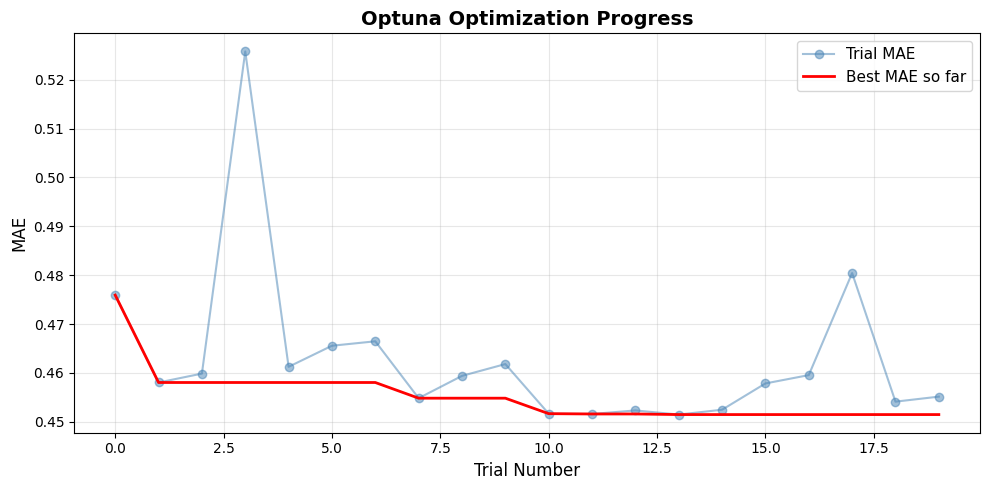

The red line shows the best result found so far


In [16]:
# Visualize optimization history
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials]
best_values = [min(trial_values[: i + 1]) for i in range(len(trial_values))]

plt.figure(figsize=(10, 5))
plt.plot(
    trial_numbers, trial_values, "o-", alpha=0.5, label="Trial MAE", color="steelblue"
)
plt.plot(trial_numbers, best_values, "r-", linewidth=2, label="Best MAE so far")
plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.title("Optuna Optimization Progress", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("The red line shows the best result found so far")

In [17]:
# Train final model with best hyperparameters
print("Training final model with optimized hyperparameters...\n")

best_rf = RandomForestRegressor(**study.best_params)
best_rf.fit(X_hpo_train, y_hpo_train)
y_hpo_pred = best_rf.predict(X_hpo_val)

final_r2 = r2_score(y_hpo_val, y_hpo_pred)
final_mae = mean_absolute_error(y_hpo_val, y_hpo_pred)
final_spearman = spearmanr(y_hpo_val, y_hpo_pred).correlation

print("Final model performance:")
print(f"  R²: {final_r2:.3f}")
print(f"  MAE: {final_mae:.3f}")
print(f"  Spearman ρ: {final_spearman:.3f}")

Training final model with optimized hyperparameters...

Final model performance:
  R²: 0.822
  MAE: 0.451
  Spearman ρ: 0.628


# Tips

- Different tasks (light and hard) may require different cross-validation strategies and hyperparameter ranges.
- Model training might be time-consuming; consider using smaller datasets or fewer trials for quick experiments.
- Feature engineering is iterative; keep experimenting with new features to improve performance.
- Document your experiments; keep track of what works and what doesn't.
- Working in teams: try to split tasks (data prep, feature engineering, modeling) among members for efficiency.

We are here to help you on this journey!